In [ ]:
import time
import jax
jax.config.update("jax_enable_x64", True)         # Use double precision (higher accuracy)
jax.config.update("jax_platform_name", "cpu")     # Force computations to run on CPU

import jax.numpy as jnp
from jax import lax

print(f"Running on: {jax.default_backend().upper()}")   # Display which backend is being used

# --------------------
# 1.Physical / domain
# --------------------
k = 200.0     # Thermal conductivity (W/m·K)
L = 1.0       # Length of the square domain (meters)
Nx = Ny = 400   # Number of grid points in x and y directions
dx = dy = L / (Nx - 1)  # Grid spacing (distance between points)

# Create coordinate grids for x and y
x = jnp.linspace(0.0, L, Nx)
y = jnp.linspace(0.0, L, Ny)
X, Y = jnp.meshgrid(x, y, indexing="xy")    # 2D coordinate arrays

# Define center and radius of circular domain
cx, cy = L/2, L/2
R_domain = 0.5

# 2. Masks — Define the area where the physics apply
# Compute squared distance from center for every grid point
r2 = (X - cx)**2 + (Y - cy)**2
# The domain is a circle of radius R_domain
domain_mask = r2 <= R_domain**2           # disk where solution is defined
fixed_mask  = ~domain_mask                # outside disk: Dirichlet u=0

# 3.Source (uniform inside r0, can be same as domain)
r0 = 0.5        # Source radius (same as domain radius here)
source_mask = r2 <= r0**2   # Where heat is being added
q_dot = 1e6     # Heat generation rate (W/m³)

# Compute Q = heat generation per conductivity (source term for PDE)
# This represents how strongly the temperature increases where heat is applied
# For u_t = ∇²u + Q, use Q = q_dot/k inside source
Q = jnp.where(source_mask, q_dot / k, 0.0)  # K/s units (since ∇²u has 1/s units when nondimensionalized with dx^2)

# 4.Initial condition
u0 = jnp.zeros((Ny, Nx))    # Initial temperature field

# --------------------
# 5.RK4 kernels
# We’ll use the Runge-Kutta 4 (RK4) method to simulate time evolution
# until the system reaches steady state (temperature stops changing)
# --------------------
dx2 = dx * dx   # Precompute dx² for Laplacian calculations

@jax.jit
def enforce_bc(u, fixed_mask):
    #Enforces boundary conditions.
    #Any point outside the circular domain is fixed to 0 (Dirichlet boundary).
    # Dirichlet outside the disk: u=0
    return jnp.where(fixed_mask, 0.0, u)

@jax.jit
def rhs(u, Q, dx2, fixed_mask):
    # du/dt = ∇²u + Q on the interior; zero time-derivative outside to maintain BCs
    # Compute the discrete Laplacian (second spatial derivative)
    lap_core = (
        u[2:, 1:-1] + u[:-2, 1:-1] + u[1:-1, 2:] + u[1:-1, :-2] - 4.0 * u[1:-1, 1:-1]
    ) / dx2
    # Combine Laplacian with source term Q
    du = jnp.zeros_like(u).at[1:-1, 1:-1].set(lap_core + Q[1:-1, 1:-1])
    # zero out derivative where u is fixed (keeps BCs constant during stages)
    du = jnp.where(fixed_mask, 0.0, du)
    return du

@jax.jit
def rk4_step(u, Q, dx2, fixed_mask, dt):
    # classic RK4
    #Performs one Runge-Kutta 4 (RK4) integration step.
    #This is a high-accuracy method for advancing time-dependent systems.
    k1 = rhs(u, Q, dx2, fixed_mask)
    k2 = rhs(enforce_bc(u + 0.5 * dt * k1, fixed_mask), Q, dx2, fixed_mask)
    k3 = rhs(enforce_bc(u + 0.5 * dt * k2, fixed_mask), Q, dx2, fixed_mask)
    k4 = rhs(enforce_bc(u + dt * k3, fixed_mask), Q, dx2, fixed_mask)

    # Weighted combination of the four derivative estimates
    u_new = u + (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    u_new = enforce_bc(u_new, fixed_mask)
    return u_new

@jax.jit
def max_err(u_new, u, domain_mask):
    #Computes the largest change in temperature between two iterations,
    #only inside the valid domain.
    mask = domain_mask.astype(u.dtype)
    return jnp.max(jnp.abs(u_new - u) * mask)

# --------------------
# 6.Time loop (to steady state)
# --------------------
tolerance = 1e-15       # Stop when temperature change is very small
max_iter = 400000       # Safety limit on number of iterations
print_interval = 10000  # How often to print progress

# Stable time step (for numerical stability in explicit diffusion)
dt = 0.1 * dx2

def body_fun(state):
    #Single iteration of the time loop:
    #1. Perform one RK4 step.
    #2. Compute how much the solution changed.
    #3. Optionally print progress.
    u, it, err = state
    u_new = rk4_step(u, Q, dx2, fixed_mask, dt)
    err_new = max_err(u_new, u, domain_mask)
    
    # Print iteration and current error occasionally
    def _do_print(_):
        jax.debug.print("Iteration {i:6d} | Error = {e:.6e}", i=it, e=err_new, ordered=True)
        return None
    lax.cond((it % print_interval) == 0, _do_print, lambda _: None, operand=None)

    return (u_new, it + 1, err_new)

def cond_fun(state):
    #Loop continues while error > tolerance and iteration < max_iter.
    _, it, err = state
    return jnp.logical_and(err > tolerance, it < max_iter)

# --------------------
# 7.Timing starts here
# --------------------
start_time = time.perf_counter()

# Initialize loop state: (temperature field, iteration counter, error)
state0 = (u0, jnp.array(0, dtype=jnp.int32), jnp.array(jnp.inf))

# Run while loop until steady-state
u_final, it_final, err_final = lax.while_loop(cond_fun, body_fun, state0)

end_time = time.perf_counter()
wall_time = end_time - start_time

print(f"Stopped at it={int(it_final)} with error={float(err_final):.6e}")
print(f"Wall time: {wall_time:.3f} seconds")

# --------------------
# 8.Analytical comparison (steady solution on a disk)
# --------------------
# The analytical steady-state solution for a circular plate with
# uniform heat generation and zero temperature at the boundary is:
# T(r) = (q_dot / (4k)) * (R² - r²)
# where r is the distance from the center.
R = R_domain
T_analytical = 0.25 * (q_dot / k) * (R**2 - ((X - cx)**2 + (Y - cy)**2))
T_analytical = jnp.where(domain_mask, T_analytical, 0.0)    # Zero outside the circle

# Compute error between numerical and analytical results
err_field = (u_final - T_analytical) * domain_mask.astype(u_final.dtype)

# Compute different error norms for accuracy evaluation
Linf = float(jnp.max(jnp.abs(err_field)))           # Maximum error
L2   = float(jnp.sqrt(jnp.mean(err_field**2)))      # RMS error
L1   = float(jnp.mean(jnp.abs(err_field)))          # Mean absolute error
print(f"L∞ error: {Linf:.3e} K | L2: {L2:.3e} K | L1: {L1:.3e} K")

Running on: CPU
Iteration      0 | Error = 3.140684e-03
Iteration  10000 | Error = 3.140398e-03
Iteration  20000 | Error = 3.099769e-03
Iteration  30000 | Error = 2.928818e-03
Iteration  40000 | Error = 2.662288e-03
Iteration  50000 | Error = 2.365292e-03
Iteration  60000 | Error = 2.075589e-03
Iteration  70000 | Error = 1.809401e-03
Iteration  80000 | Error = 1.571813e-03
Iteration  90000 | Error = 1.362854e-03
Iteration 100000 | Error = 1.180482e-03
Iteration 110000 | Error = 1.021958e-03
Iteration 120000 | Error = 8.844643e-04
Iteration 130000 | Error = 7.653481e-04
Iteration 140000 | Error = 6.622179e-04
Iteration 150000 | Error = 5.729583e-04
Iteration 160000 | Error = 4.957176e-04
Iteration 170000 | Error = 4.288841e-04
Iteration 180000 | Error = 3.710586e-04
Iteration 190000 | Error = 3.210283e-04
Iteration 200000 | Error = 2.777431e-04
Iteration 210000 | Error = 2.402939e-04
Iteration 220000 | Error = 2.078940e-04
Iteration 230000 | Error = 1.798626e-04
Iteration 240000 | Error

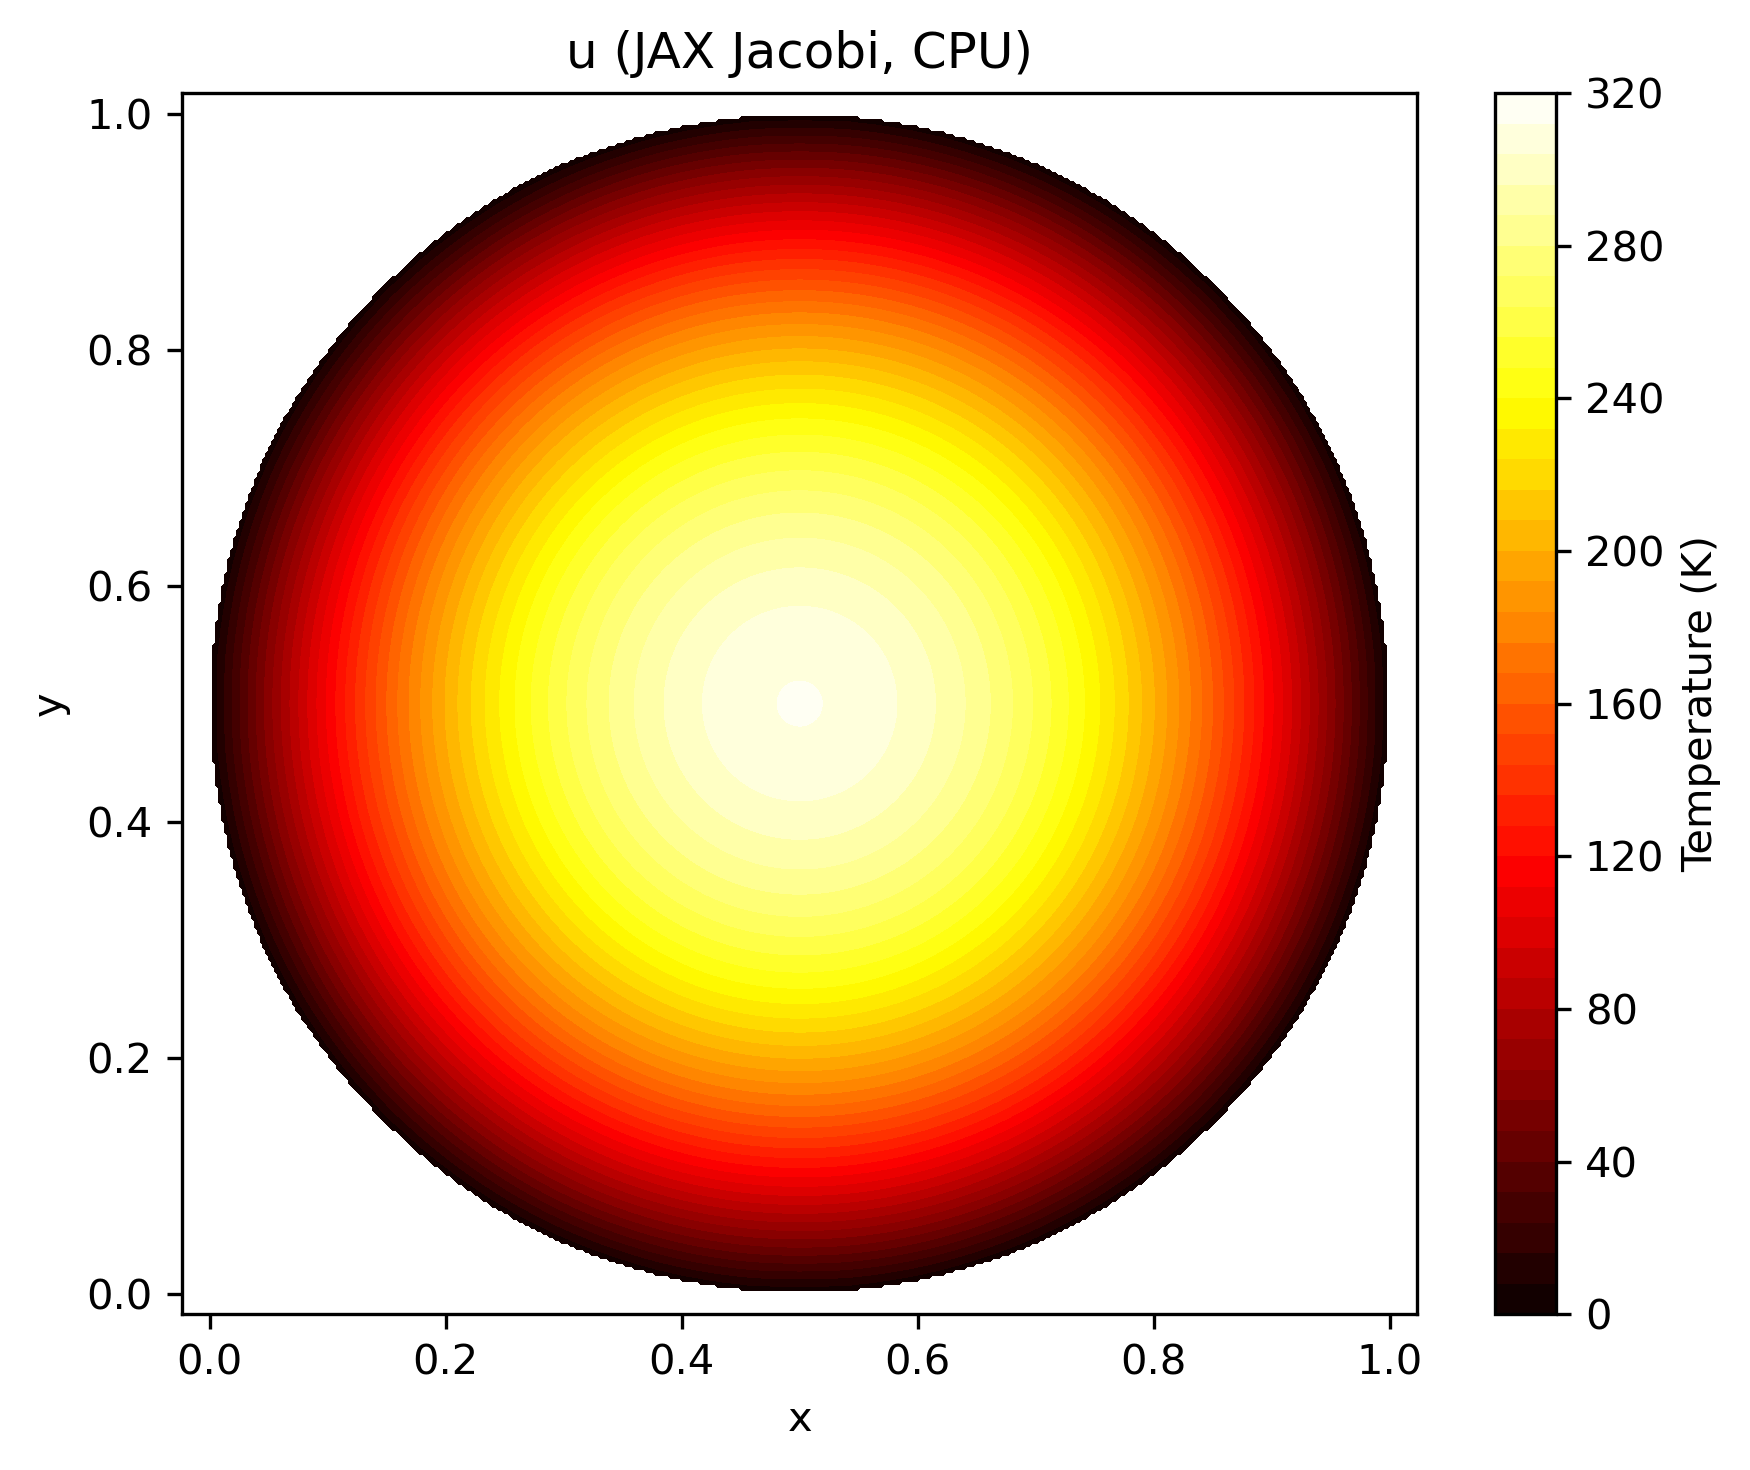

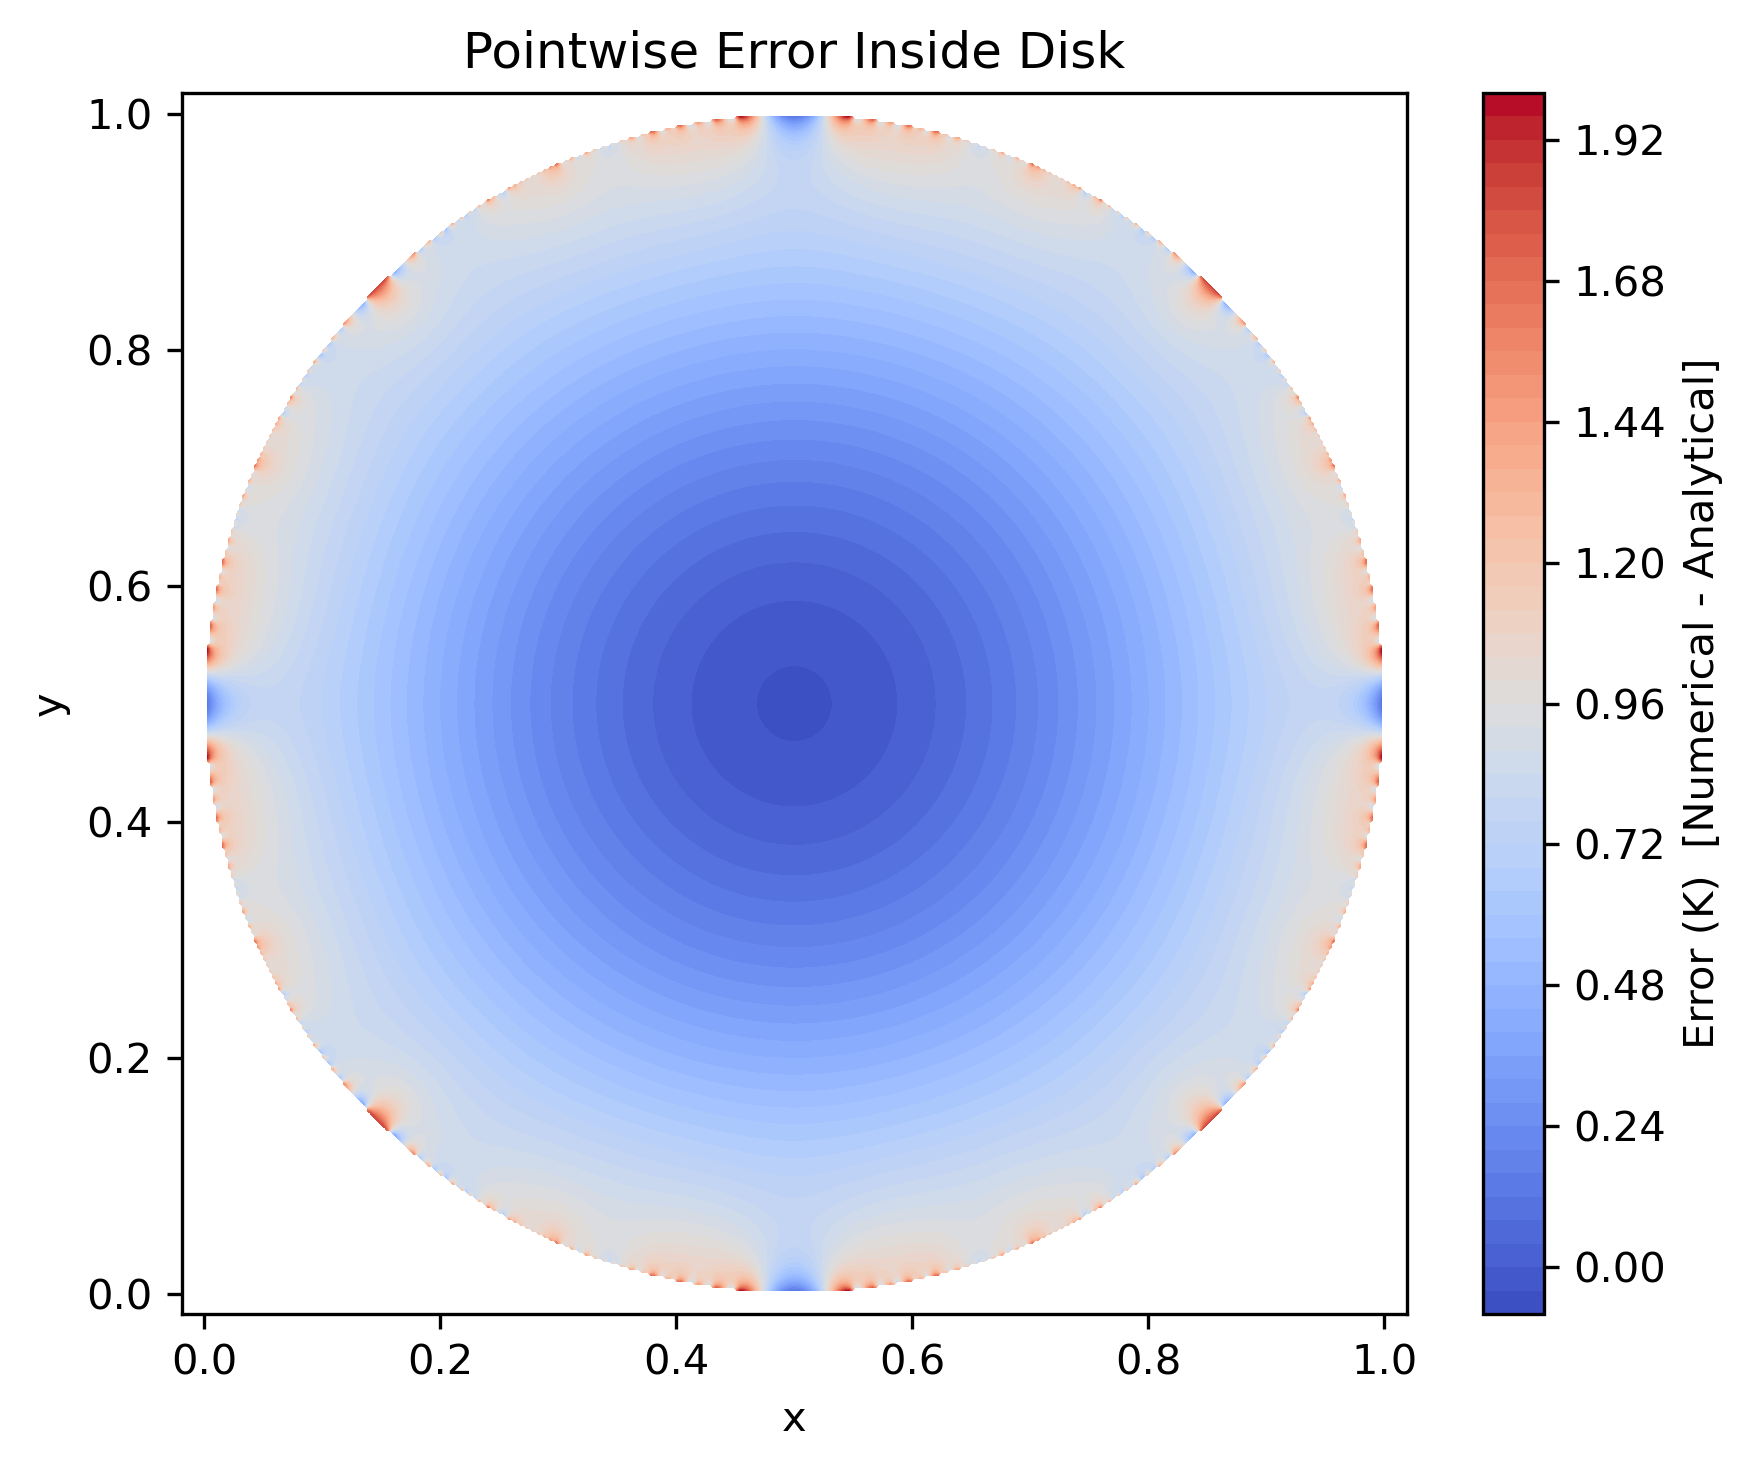

In [ ]:
# Import plotting libraries (only need to do this once)
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma       # Used to "mask out" regions we don’t want to show

# --------------------
# 1.Plot (host)
# Convert JAX arrays (which live on CPU/GPU memory) into NumPy arrays
# so matplotlib can plot them.
# --------------------
u_np = np.array(u_final)        # Final temperature field
domain_mask_np = np.array(domain_mask)  # Mask of points inside the circular domain
X_np, Y_np = np.array(X), np.array(Y)   # Coordinate grids

# Mask out any values outside the circular domain (so they don’t show in the plot)
u_masked = ma.masked_where(~domain_mask_np, u_np)

# 2. Plot Temperature Distribution
plt.figure(figsize=(6, 5), dpi=300)     # Create a high-quality figure
plt.contourf(X_np, Y_np, u_masked, levels=50, cmap='hot')       # Filled contour plot of temperature
plt.colorbar(label='Temperature (K)')                           # Add color scale on the side
plt.title("u (JAX Jacobi, CPU)")                                # Add descriptive title
plt.xlabel('x'); plt.ylabel('y')
plt.axis('equal')                       # Keep x and y scales equal (so the circle looks round) 
plt.tight_layout()                      # Automatically adjust spacing
plt.savefig('neumann_circular_contour.png', dpi=300)    # Save the plot as a PNG file
plt.show()      # Display the plot on screen

# 3. Plot Error Between Numerical and Analytical Solutions
# This shows how far off the computed result is from the exact math solution
err_np = np.array(err_field)        # Convert the error field from JAX to NumPy
# Mask outside the domain so only the valid region is shown
err_masked = ma.masked_where(~domain_mask_np, err_np)

plt.figure(figsize=(6, 5), dpi=300)
plt.contourf(X_np, Y_np, err_masked, levels=50, cmap='coolwarm')    # Blue/red for positive/negative error
plt.colorbar(label='Error (K)  [Numerical - Analytical]')
plt.title("Pointwise Error Inside Disk")        # Title of the plot
plt.xlabel('x'); plt.ylabel('y'); plt.axis('equal'); plt.tight_layout()
plt.savefig('error_contour.png', dpi=300)       # Save as PNG
plt.show()      # Display the plot

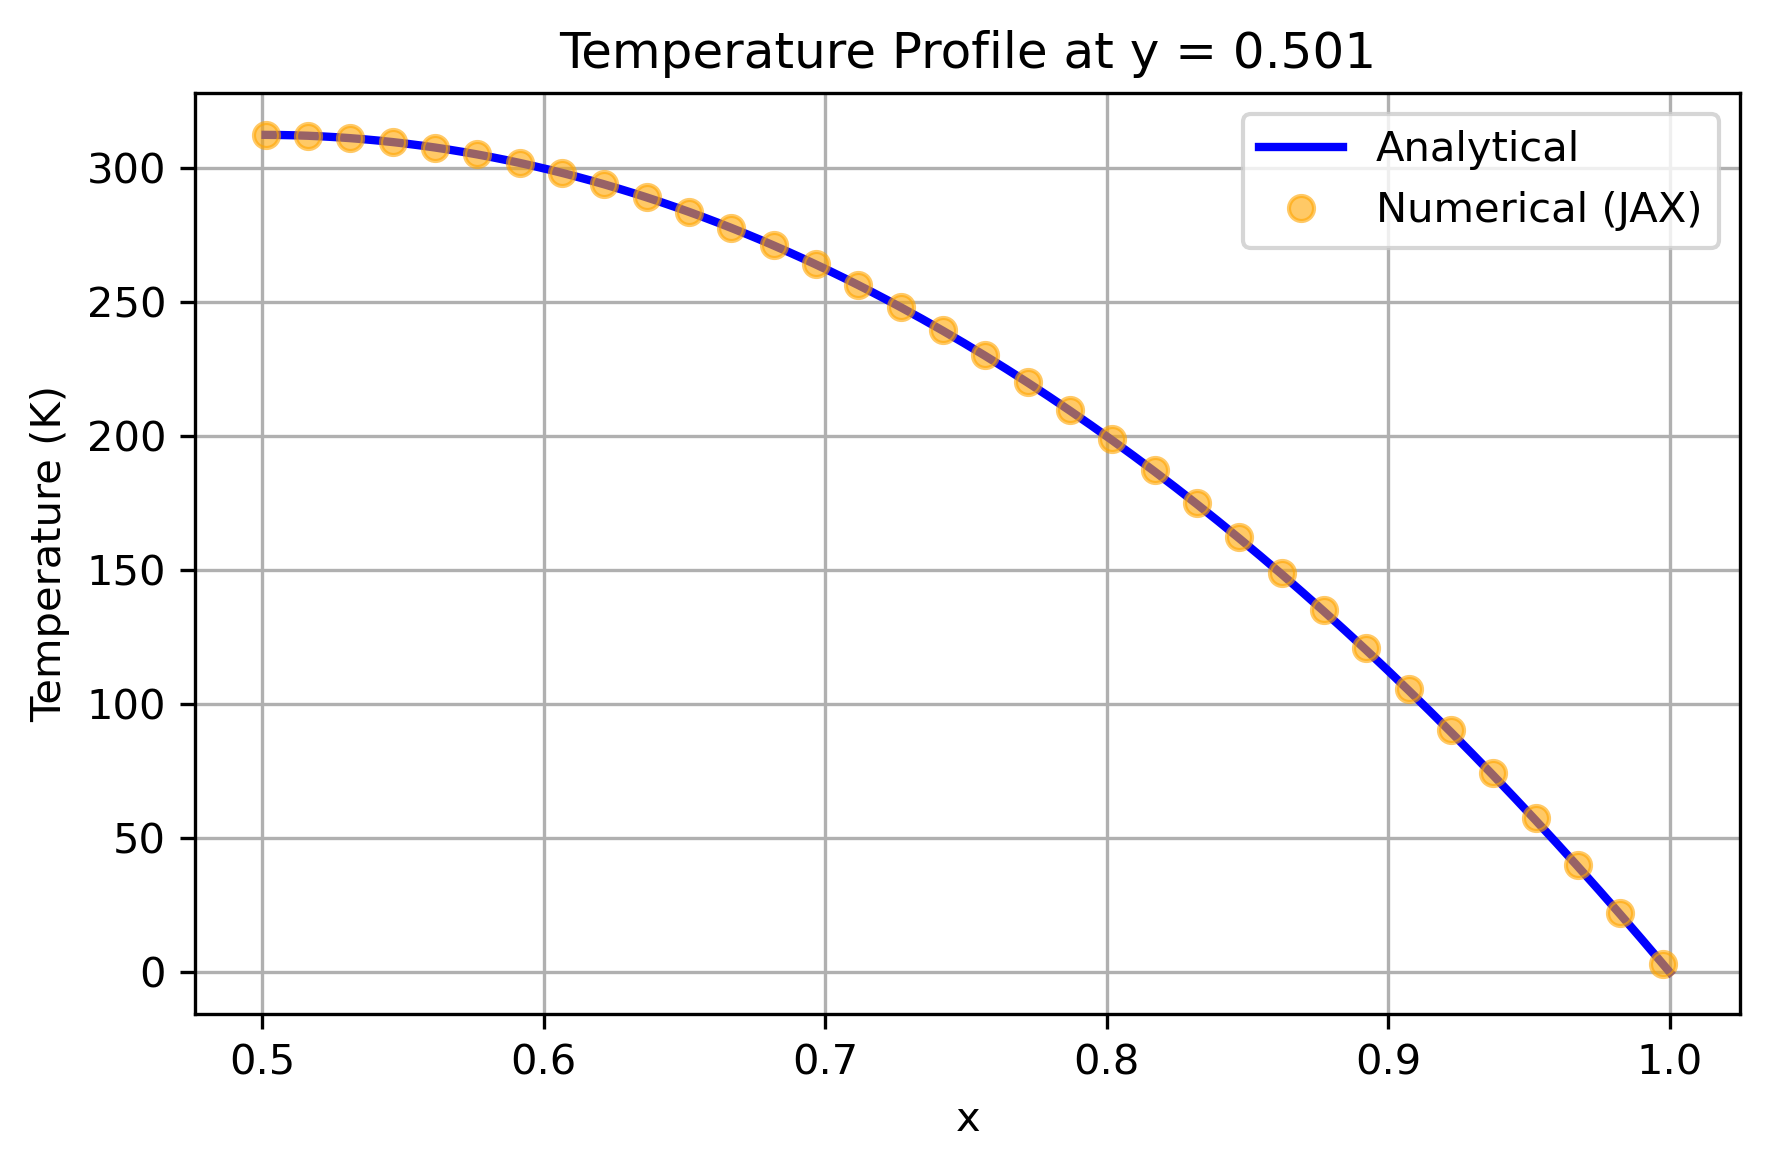

In [ ]:
# ---------- Temperature profile at y = 0.5, x in [0.5, 1.0] ----------
# Convert coordinate lists/arrays to NumPy arrays for easy numerical operations
x_np = np.array(x)
y_np = np.array(y)

# Define the y-value (vertical position) where we’ll extract the temperature slice
y_target = 0.5
# Find the index of the grid row that’s closest to y = 0.5
y_index = int(np.abs(y_np - y_target).argmin())

# Define x-range for the right half of the domain (from the center to the outer boundary)
x_start, x_end = 0.5, 1.0
# Create a boolean mask selecting only x values within that range
x_mask = (x_np >= x_start) & (x_np <= x_end)
# Extract the x-coordinates and corresponding numerical temperature values for that slice
x_profile = x_np[x_mask]
u_profile = u_np[y_index, x_mask]

# Compute the analytical temperature profile along this horizontal line
# The analytical solution for steady-state heat conduction in a disk is parabolic in r
r_profile = np.abs(x_profile - cx)      # radial distance from the circle center
T_profile_analytical = 0.25 * (q_dot / k) * (R_domain**2 - r_profile**2)

# Downsample data to plot fewer numerical points (for clarity)
step = 6
x_profile_sparse = x_profile[::step]
u_profile_sparse = u_profile[::step]

# ---------- Plot temperature comparison ----------
plt.figure(figsize=(6, 4), dpi=300)
# Plot analytical (continuous) curve
plt.plot(x_profile, T_profile_analytical, color='blue', lw=2, label='Analytical')
# Overlay numerical results (discrete points)
plt.plot(x_profile_sparse, u_profile_sparse, 'o', color='orange', markersize=6, alpha=0.6, label='Numerical (JAX)')
# Add labels, title, grid, and legend
plt.title(f"Temperature Profile at y = {y_np[y_index]:.3f}")
plt.xlabel("x")
plt.ylabel("Temperature (K)")
plt.grid(True)
plt.legend()
plt.tight_layout()
# Save figure and display
plt.savefig('neumann_circular_plot.png', dpi=300)
plt.show()